[View in Colaboratory](https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/Poisson_Colab.ipynb)

# Kiến thức nền tảng

In [0]:
# This demo adapts an existing code to solve the Poisson equation
# The orignal code is available here: https://fenicsproject.org/tutorial/

"""
FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.

  -Laplace(u) = f    in the unit square
            u = u_D  on the boundary

  u_D = 1 + x^2 + 2y^2
    f = -6
"""

# Original code is available at https://fenicsproject.org/tutorial/


Phương trình Poisson được định nghĩa trên một miền tính toán $\Omega$ có dạng như sau:

$$-\Delta u=f$$

Phương trình cần được bổ sung với một hoặc vài điều kiện trên biên $\partial \Omega$. Ở đây giả sử điều kiện Dirichlet được sử dụng

$$u = u_D \text{ on } \partial \Omega$$

Để kiểm tra tính chính xác của việc cài đặt thuật toán, người ta thường giả sử nghiệm đã biết trước là hàm $u_e$ nào đó. Giả sử $u_e=1 + x^2 + 2\,y^2$, ta có thể tính được nguồn $f=-\Delta u_e=-6$ và trên biên thì $u_D=u_e$.

Để giải phương trình, người ta cần biết sẽ tìm nghiệm ở đâu. Vì vậy, không gian hàm cần được định nghĩa. Trước hết mình chọn không gian hàm cho nghiệm cần tìm (trial function space) 

$$V=\Biggl\{u:\Omega\to\mathbb{R}\,\Biggl| \,\int\limits_\Omega u^2 + |\nabla u|^2\,d\Omega<\infty, u=u_D\text{ on }\partial \Omega\Biggl\}$$

Nghiệm của PPPTHH là nghiệm yếu (weak solution), vì vậy người ta cần chọn thêm không gian hàm kiểm tra (test function space)

$$\hat{V}=\Biggl\{v:\Omega\to\mathbb{R}\,\Biggl| \,\int\limits_\Omega v^2 + |\nabla v|^2\,d\Omega<\infty, v=0\text{ on }\partial \Omega\Biggl\}$$

Muốn tìm nghiệm $u$ trong trial function space $V$, đầu tiên, người ta nhân 2 vế của phương trình Poisson với một test function $v\in \hat{V}$ và lấy tích phân trên $\Omega$

$$\displaystyle -\int\limits_{\Omega} \Delta u\, v\, d\Omega= \int\limits_{\Omega} f\, v\, d\Omega.$$

Áp dụng công thức Green thứ nhất, i. e.

$$\displaystyle \int\limits_{\Omega} \Delta u\, v\, d\Omega=\int\limits_{\partial\Omega} \nabla u\cdot \mathbf{n}\, v\, ds - \int\limits_{\Omega} \nabla u \cdot\nabla v\, d\Omega,$$

Do định nghĩa của $\hat{V}$, cụm liên quan đến biên bị triệt tiêu

$$\displaystyle \int\limits_{\Omega} \nabla u \cdot\nabla v\, d\Omega=\int\limits_{\Omega} f\, v\, d\Omega$$.


PPPTHH được diễn đạt như sau: Tìm $u\in V$ sao cho

$$a(u,v)=L(v)$$ cho tất cả $v\in \hat{V}$. Ở đây 

$\displaystyle a(u,v)=\int\limits_{\Omega} \nabla u \cdot\nabla v\, d\Omega$ được gọi là bilinear form.


$\displaystyle L(v)=\int\limits_{\Omega} f\, v\, d\Omega$ được gọi là linear form.

Chú ý không gian hàm trên đây là liên tục và vô hạn chiều. Người ta muốn tìm nghiệm xấp xỉ trên không gian hữu hạn chiều.

# Setting a working environment with FEniCS

In [1]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

E: Package 'python-software-properties' has no installation candidate
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [83.2 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [235 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [526 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [718 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Get:12 http://ppa.launchpad.net

# The Poisson solver

error_L2  = 0.005270462766948929
error_max = 3.3306690738754696e-15


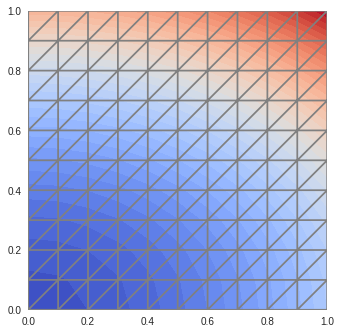

In [3]:
from __future__ import print_function
from fenics import *

# Create mesh and define function space
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, 'CG', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution and mesh
plot(u,cmap="coolwarm")
plot(mesh)

# Save solution to file in VTK format
vtkfile = File('solution.pvd')
vtkfile << u

# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)